## This notebook demonstrates setup and running the component LandslideProbability on a small basin in the Olympic Experiment State Forest, Washington State



### import landlab raster model grid and other python packages needed for running and visualizing the model

In [1]:
# setup
import os

## import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## import necessary landlab components
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, LandslideProbability, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                                FlowDirectorDINF, 
                                FlowDirectorMFD, 
                                FlowDirectorSteepest)

from landlab.components.mass_wasting_router import MassWastingRunout

## import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from landlab import imshow_grid_at_node

## import functions
from landlab.io.esri_ascii import write_esri_ascii
from landlab.io import read_esri_ascii
from landlab.io.netcdf import read_netcdf

from landlab.components import ChannelProfiler, FlowAccumulator, DepressionFinderAndRouter


from landlab.components.mass_wasting_router.landslide_mapper import LandslideMapper as LM
from landlab.components.mass_wasting_router import MassWastingRunout 


### import other custom plotting code and functions

In [2]:
os.chdir('C:/Users/keckje/Documents/GitHub/code/landlab/LandlabTools')
import LandlabTools as LLT

os.chdir('C:/Users/keckje/Documents/GitHub/landlab/landlab/components/mass_wasting_router')
from mwru_calibrator import (MWRu_calibrator,
                                profile_distance,
                                profile_plot,
                                view_profile_nodes)

os.chdir('C:/Users/keckje/Documents/GitHub/code/preevents/paper2/')
import MassWastingRunoutEvaluationFunctions as MWF


### import gis generated inputs (DEM) and set notebook controls

In [3]:
#%%script controls
svfig = 0 
svnm = '_50yrstorm_100it_v2_'
hf = 30
wf = 15


# GIS generated inputs
bdfdem = 'dem_mask.asc' # before debris flow dem
bdfdem_hs = 'dem3fths_nd27.asc' # before debris flow dem hs



mdir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/KunamasktCreek/output/p2_final/MWRu_probability/'
# GIS input file location
dem_dir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/KunamasktCreek/input/'
# file location where output will be saved
mdir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/KunamasktCreek/output/p2_final/MWRu_probability/'

### set LandslideProbability parameters
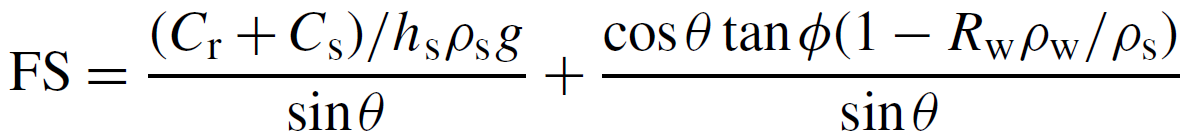

In [4]:
# LandslideProbability parameters•
number_of_iterations = 10
P_mn = 250 # daily cumulative P
P_sd = 30 # daily cumulative P standard deviation
ro_v = 2650*(1-.4) #density, density of solid rock * 1-porosity kg/m3
phi_v = 32 #50 #friction angle, degrees
ssc = 3000
Cmax_v = 11000+ssc #150 # max soil cohesion Pa
Cmin_v = 3300+ssc#50 #min soil cohesion
Cmode_v = 5000+ssc #100 #mode soil cohesion
Kast_v = 2 # soil__saturated_hydraulic_conductivity m/day


# mapper
Ct = 10000 # contributing area threshold for channel initiation
BCt = 300000 # contributing area threshold for bedload channel initiation
MW_to_channel_threshold = 50 # max distance from channel that a mass wasting cell causes hillslope failure to channel
mass_wasting_threshold = 1
threshold_type = "less_than"
min_mw_cells = 2


# runout parameters
# average thickness of landslide
mw_id = 1
Sc = 0.11 # critical slope

para = {'SD':[0.1,.4,0.25],       # minimum unit flox and coefficient
               'cs':[0.01, 0.04, 0.02]}
npu = [1]
nid = [1]
slpc = [Sc] #0.03
SV = para['SD'][2]
cs = para['cs'][2]
mw_dict = {'critical slope':slpc, 'minimum flux':SV,
            'scour coefficient':cs}
release_dict = {'number of pulses':npu, 'iteration delay':nid }


# grain size 
u_D = 0.65
l_D = 0.95


### load topography field into the grid and use Landlab to create the hillshade

In [5]:
# load existing landscape dem
mg, z = read_esri_ascii(dem_dir+bdfdem, name='topographic__elevation')
sz = z.shape 

# hillshade for plots
mg.at_node['hillshade'] = mg.calc_hillshade_at_node(elevs=z, alt=30., az=210.)

# set boundary conditions
mg.status_at_node[np.isclose(z, -9999.)] = mg.BC_NODE_IS_CLOSED
mg.set_watershed_boundary_condition(z) #finds lowest point in dem and sets it as an open node

# soil depth
(gt7, depth) = read_esri_ascii(dem_dir+'soild_nomask.asc', name='soil__thickness') 
mg.add_field('node', 'soil__thickness',depth)


array([-9999., -9999., -9999., ..., -9999., -9999., -9999.])

### view initial fields stored on the raster model grid

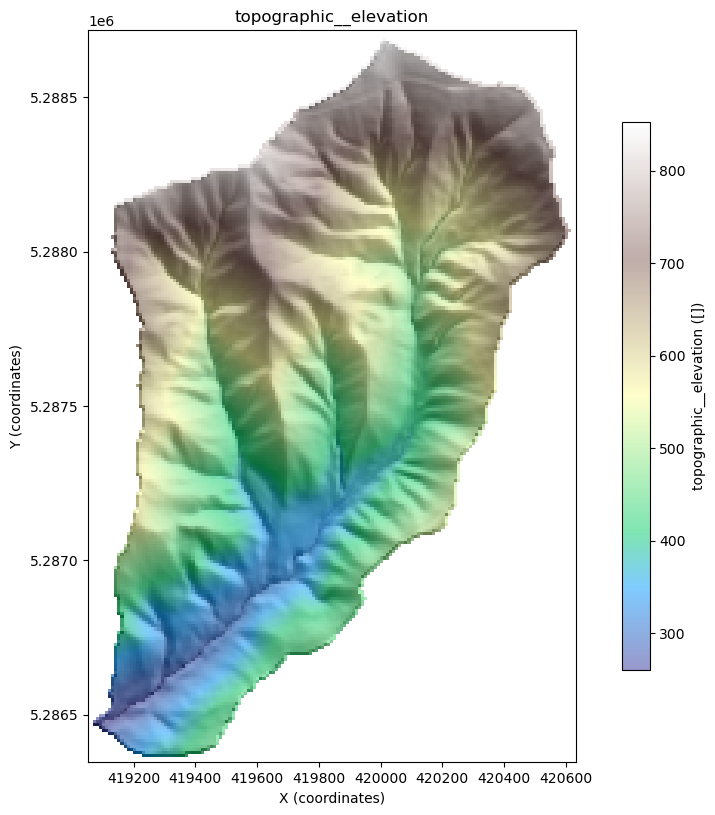

In [6]:
LLT.plot_node_field_with_shaded_dem(mg,field = 'topographic__elevation', fontsize = 10)

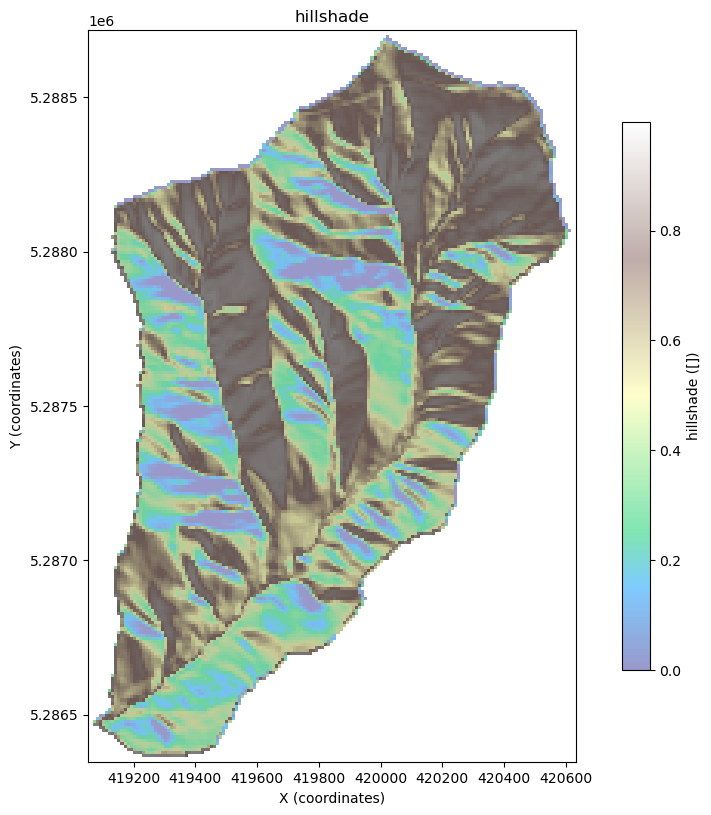

In [7]:
LLT.plot_node_field_with_shaded_dem(mg,field = 'hillshade', fontsize = 10)

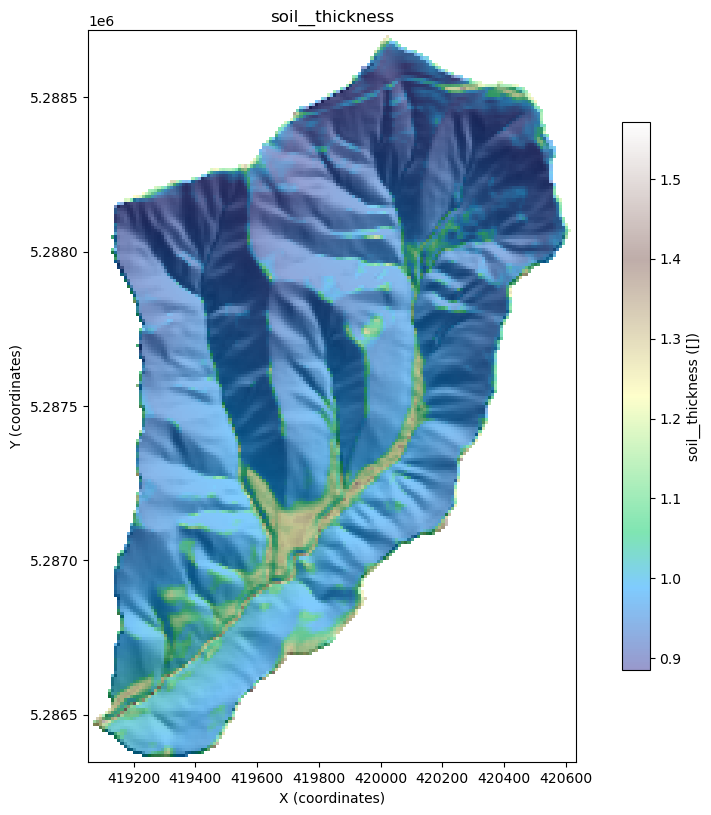

In [8]:
LLT.plot_node_field_with_shaded_dem(mg,field = 'soil__thickness', fontsize = 10)

### load LandslideProbability parameters into the grid

In [9]:
# give particale diameter, north of 5288000 is coarse sandstone
# mg.at_node['particle__diameter'] = np.ones(len(depth))*l_D
# mg.at_node['particle__diameter'][mg.node_y>5288000] = u_D

# create landslide parameter arrays
ro = np.ones(sz)*ro_v # density, density of solid rock * 1-porosity kg/m3
phi = np.ones(sz)*phi_v # friction angle, degrees
Cmax = np.ones(sz)*Cmax_v # max soil cohesion kPa
Cmin = np.ones(sz)*Cmin_v # min soil cohesion
Cmode = np.ones(sz)*Cmode_v # mode soil cohesion
Ksat =  np.ones(sz)*Kast_v # soil__saturated_hydraulic_conductivity m/day

# soil tranmisivity, m2/day
T = Ksat*depth


# DEM metrics, compute with landlab functions

# compute slope, flow direction and fields
slope, aspect = mg.calculate_slope_aspect_at_nodes_burrough(vals='topographic__elevation',)

# Run FlowAccumulator, creates drainage area, reciever and slope fields
fr = FlowAccumulator(mg,'topographic__elevation',flow_director='D8')
fr.run_one_step()

# fill sinks to see if Flow Accumulator works better
sfb = SinkFillerBarnes(mg,'topographic__elevation', method='D8',fill_flat = False, 
                       ignore_overfill = False)
sfb.run_one_step()

fr = FlowAccumulator(mg,'topographic__elevation',flow_director='D8')
fr.run_one_step()

df_4 = DepressionFinderAndRouter(mg)
df_4.map_depressions()

# compute specific contributing area
SCA = mg.at_node['drainage_area']/mg.dx
   
# add soil parameters as fields to raster model grid
# consider making these in ArcGIS to caputre spatial variability
mg.add_field('node','soil__density', ro)
mg.add_field('node','soil__internal_friction_angle', phi)
mg.add_field('node', 'soil__maximum_total_cohesion', Cmax)
mg.add_field('node', 'soil__minimum_total_cohesion', Cmin)
mg.add_field('node', 'soil__mode_total_cohesion', Cmode)
mg.add_field('node', 'soil__saturated_hydraulic_conductivity', Ksat)
mg.add_field('node', 'soil__transmissivity', T)
mg.add_field('node', 'topographic__slope', mg.at_node['topographic__steepest_slope']) # LP needs this field name
mg.add_field('node', 'topographic__specific_contributing_area', SCA)
# initial mass_wasting_id array
mg.add_field('node', 'mass__wasting_id',(np.ones(mg.number_of_nodes)*-9999).astype(int))


array([-9999, -9999, -9999, ..., -9999, -9999, -9999])

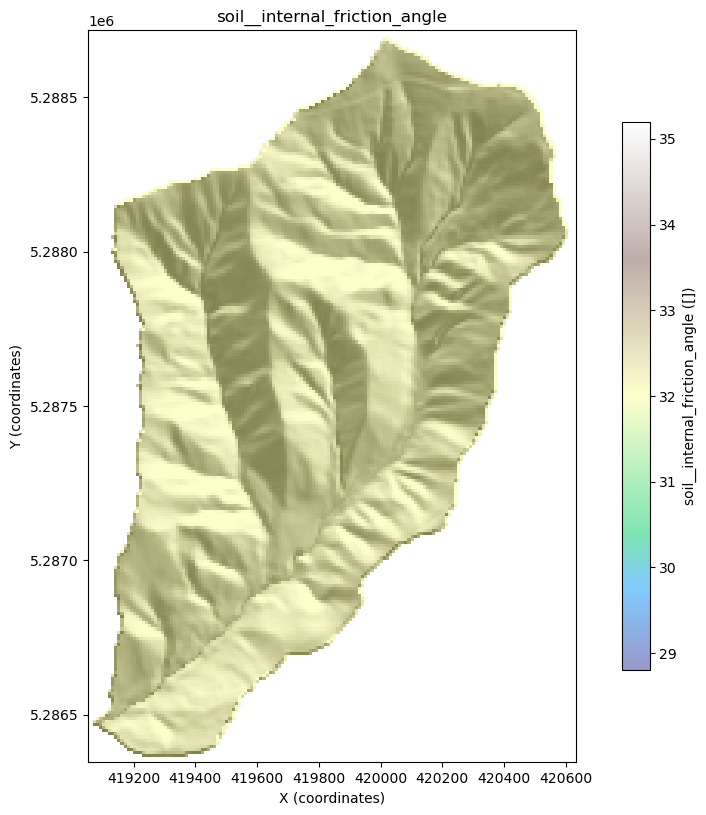

In [10]:
# view inputs
LLT.plot_node_field_with_shaded_dem(mg,field = 'soil__internal_friction_angle', fontsize = 10)

### Instantiate and run LandslideProbability

In [11]:

# specify annual daily maximum cumulative precipitation (each iteration is an annual maximum)
ls_prob = LandslideProbability(mg,
                             number_of_iterations = number_of_iterations,
                             groundwater__recharge_distribution='lognormal', 
                             groundwater__recharge_mean= P_mn, 
                             groundwater__recharge_standard_deviation = P_sd)

ls_prob.calculate_landslide_probability()

### Now, lets take a look at landslide probability

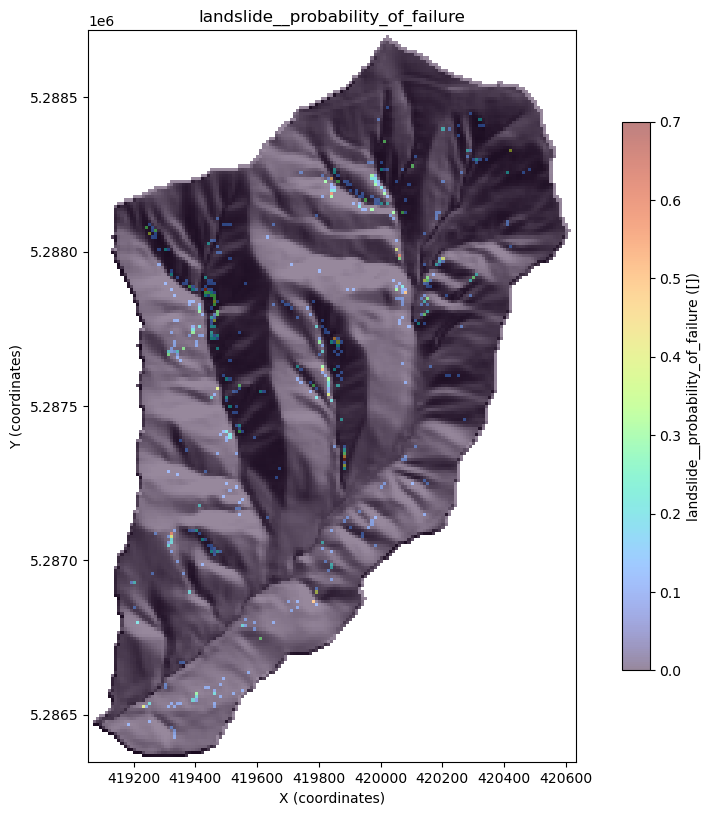

In [12]:
LLT.plot_node_field_with_shaded_dem(mg,field = 'landslide__probability_of_failure', fontsize = 10, cmap = 'turbo')

### Instantiate LandslideMapper, to convert the landslide probability map into a map of landslides
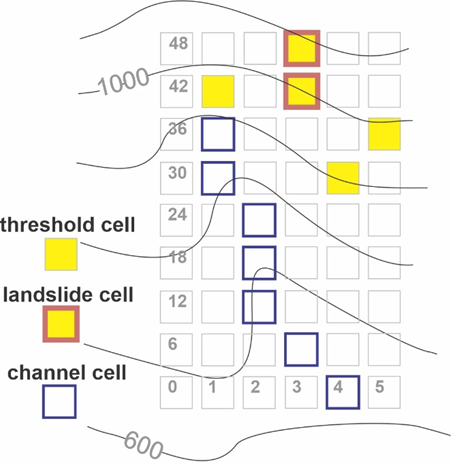

In [13]:
mg.at_node['mass__wasting_potential'] = np.ones(mg.shape[0]*mg.shape[1])*np.nan # required field to instantiate
Landslides = LM(mg,
             Ct = Ct, 
             BCt  = BCt,
             MW_to_channel_threshold = MW_to_channel_threshold, 
             mass_wasting_threshold = mass_wasting_threshold,
             threshold_type = threshold_type,
             min_mw_cells = min_mw_cells,
             )

grid
<xarray.Dataset>
Dimensions:         (node: 53915, link: 107362, Two: 2, patch: 53448,
                     max_patch_links: 4, cell: 52983, face: 106430)
Coordinates:
  * node            (node) int32 0 1 2 3 4 5 ... 53910 53911 53912 53913 53914
Dimensions without coordinates: link, Two, patch, max_patch_links, cell, face
Data variables:
    mesh            <U1 'a'
    y_of_node       (node) float64 5.286e+06 5.286e+06 ... 5.289e+06 5.289e+06
    x_of_node       (node) float64 4.188e+05 4.188e+05 ... 4.209e+05 4.209e+05
    nodes_at_link   (link, Two) int32 0 1 1 2 2 ... 53912 53913 53913 53914
    links_at_patch  (patch, max_patch_links) int32 205 409 204 ... 107156 106952
    node_at_cell    (cell) int32 206 207 208 209 210 ... 53705 53706 53707 53708
    nodes_at_face   (face, Two) int32 1 206 2 207 3 ... 53707 53912 53708 53913
grid


### Now prepare MassWastingRunout!!!

In [14]:
#%% instantiate MassWastingRunout
DebrisFlows = MassWastingRunout(mg,release_dict,mw_dict, save = False,
                                 routing_surface = "topographic__elevation", settle_deposit = False, deposition_rule = "critical_slope",
                                 deposit_style = 'downslope_deposit_sc10')

### copy the initial soil depth and topography

In [15]:
initial_soil_depth = mg.at_node['soil__thickness'].copy()
topographic__initial_elevation = mg.at_node['topographic__elevation'].copy()

### define two functions that reset the flow directions of the grid to either D8 or multidirection

In [16]:

def multidirectionflowdirector(mg):
    '''
    removes rmg fields created by d8 flow director, runs multidirectionflowdirector

    '''
    mg.delete_field(loc = 'node', name = 'flow__sink_flag')
    mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
    mg.delete_field(loc = 'node', name = 'flow__receiver_node')
    mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')
    # run flow director, add slope and receiving node fields
    fd = FlowDirectorMFD(mg, diagonals=True,
                          partition_method = 'slope')
    fd.run_one_step()


def d8flowdirector(mg):
    '''
    removes fields created by multidirectionflowdirector, runs d8flow director

    '''
    mg.delete_field(loc = 'node', name = 'flow__sink_flag')
    mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
    mg.delete_field(loc = 'node', name = 'flow__receiver_node')
    mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')
    try:
        mg.delete_field(loc = 'node', name = 'flow__receiver_proportions') # not needed?
    except:
        None

    fr = FlowAccumulator(mg,'topographic__elevation',flow_director='D8')
    fr.run_one_step()

    df_4 = DepressionFinderAndRouter(mg)
    df_4.map_depressions()

### how many times did LandslideProbability compute factor of safety?

In [17]:
ls_prob._FSarray.shape[1]

10

### 1. convert each factor of safety map into a map of landslides
### 2. view each factor of safety and landslide map

mapping the landslides, map:0
masswastingextent
mapping the landslides, map:1
masswastingextent
mapping the landslides, map:2
masswastingextent
mapping the landslides, map:3
masswastingextent
mapping the landslides, map:4
masswastingextent
mapping the landslides, map:5
masswastingextent
mapping the landslides, map:6
masswastingextent
mapping the landslides, map:7
masswastingextent
mapping the landslides, map:8
masswastingextent
mapping the landslides, map:9
masswastingextent


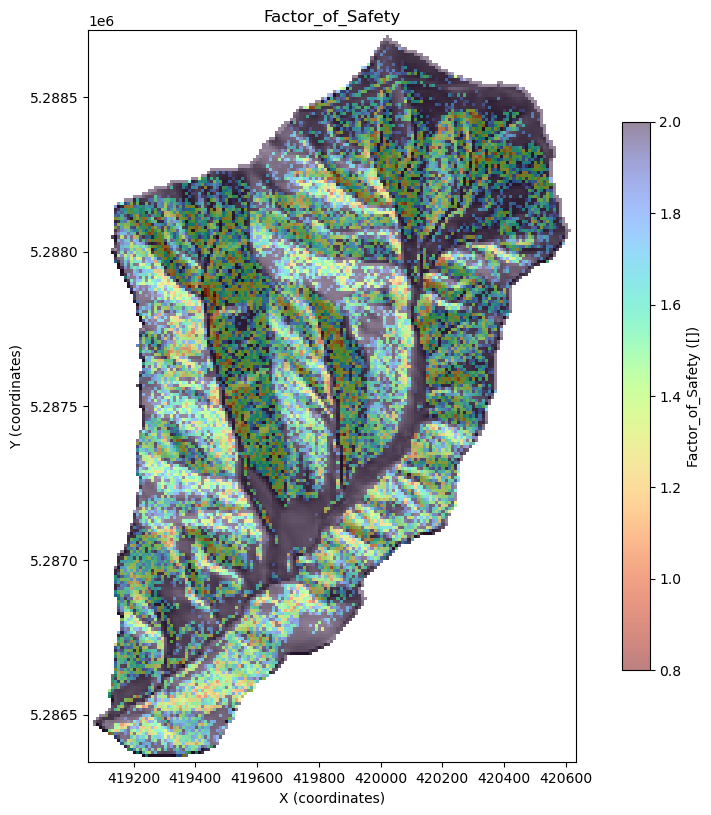

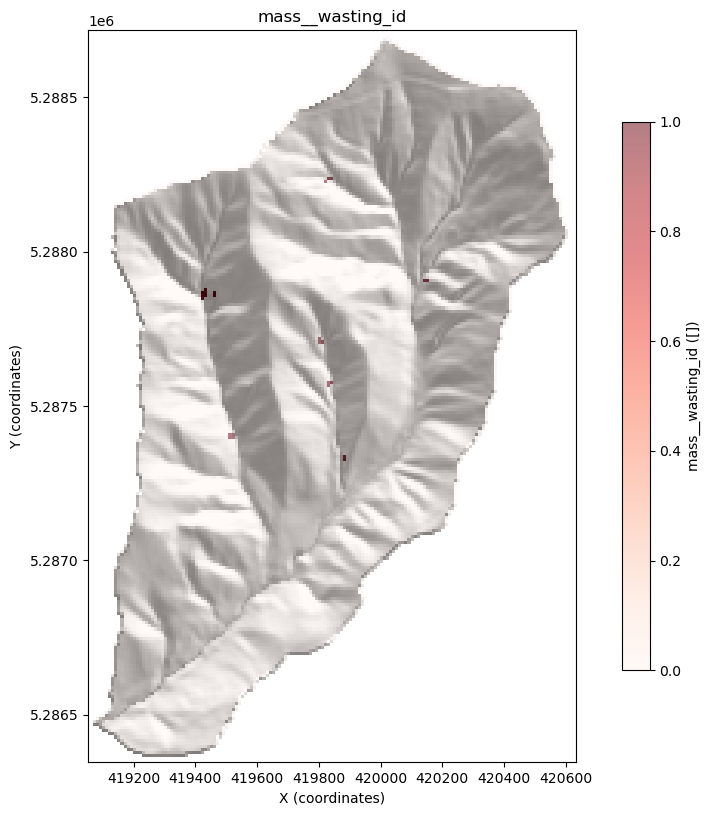

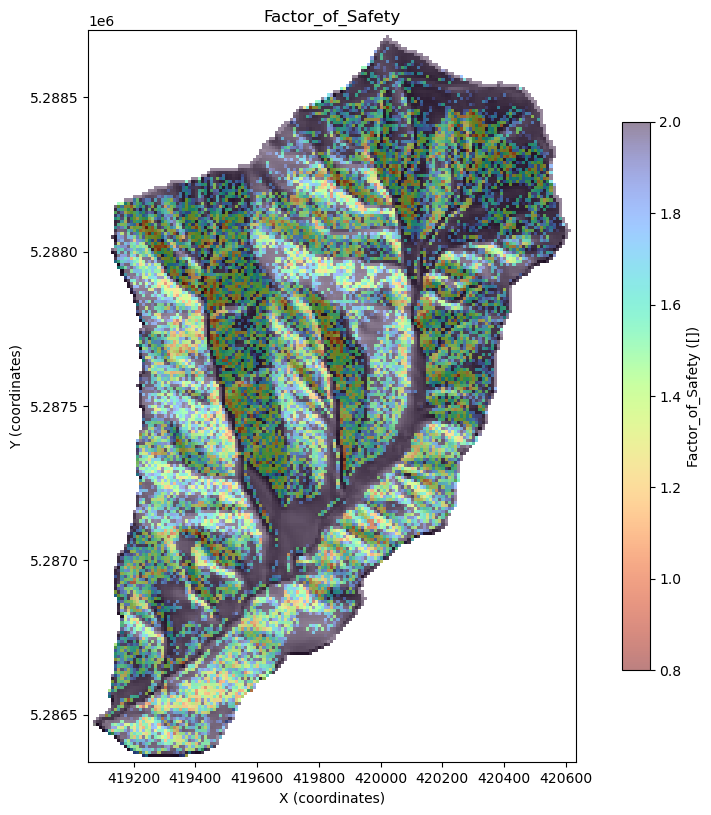

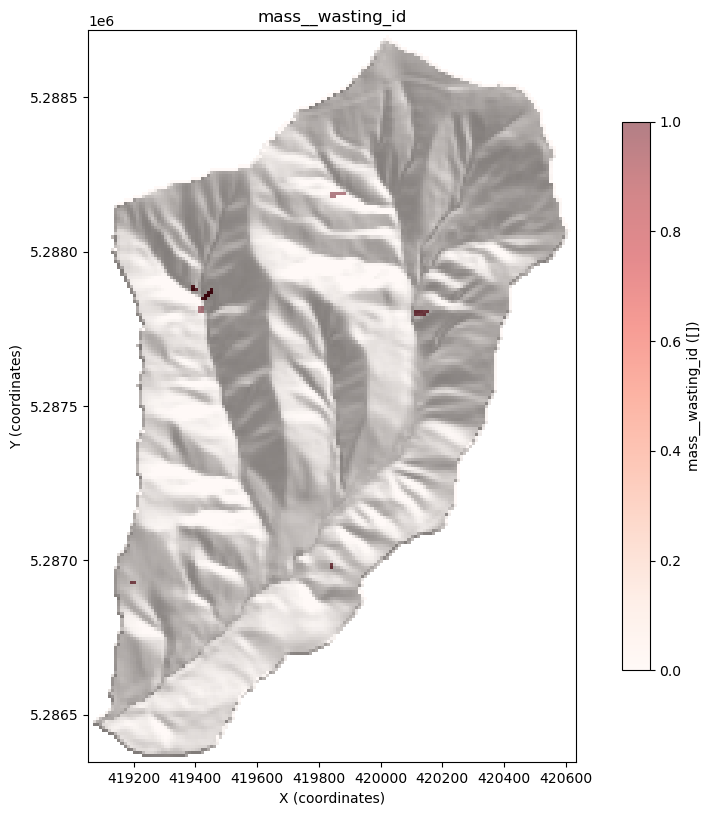

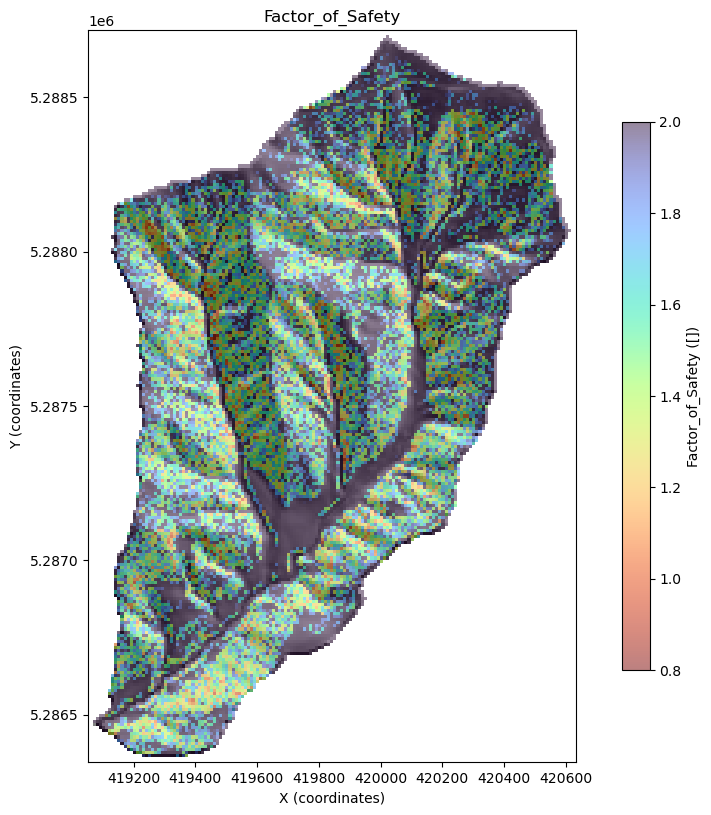

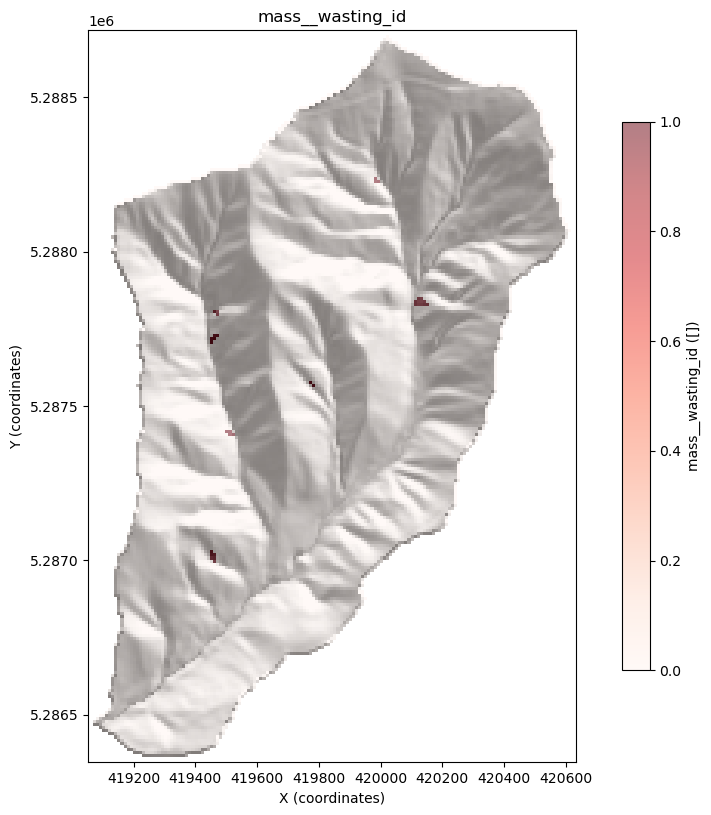

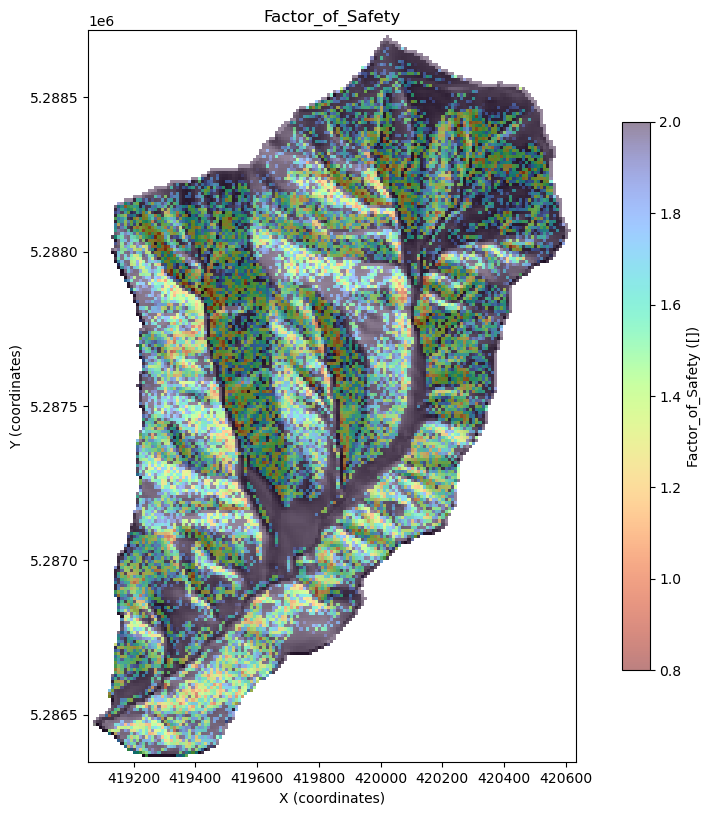

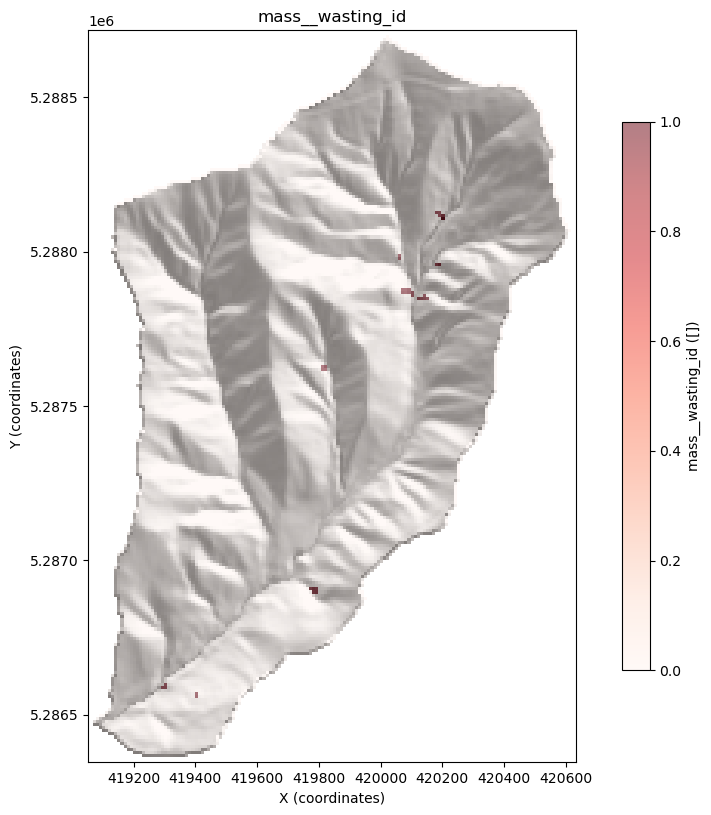

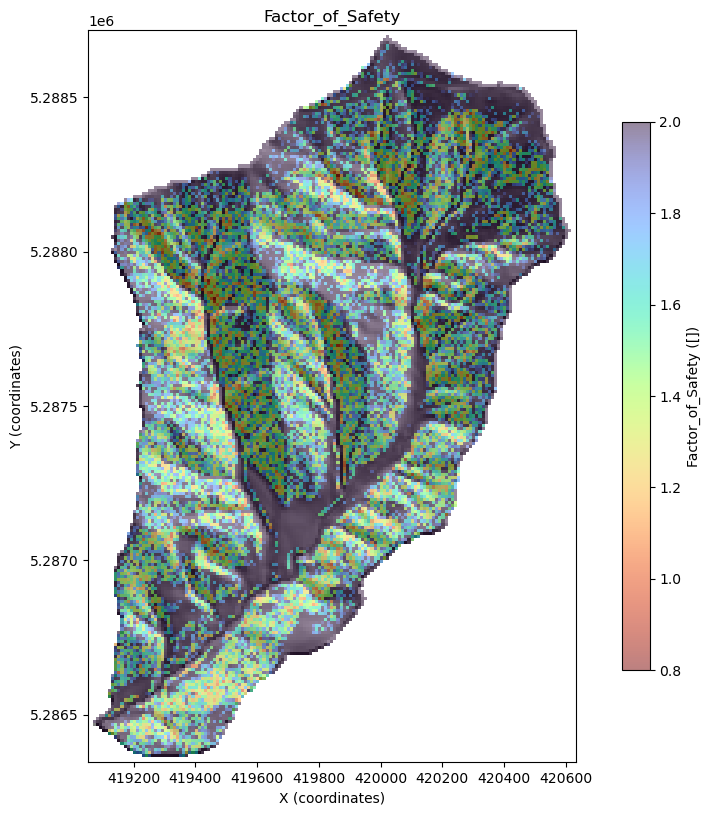

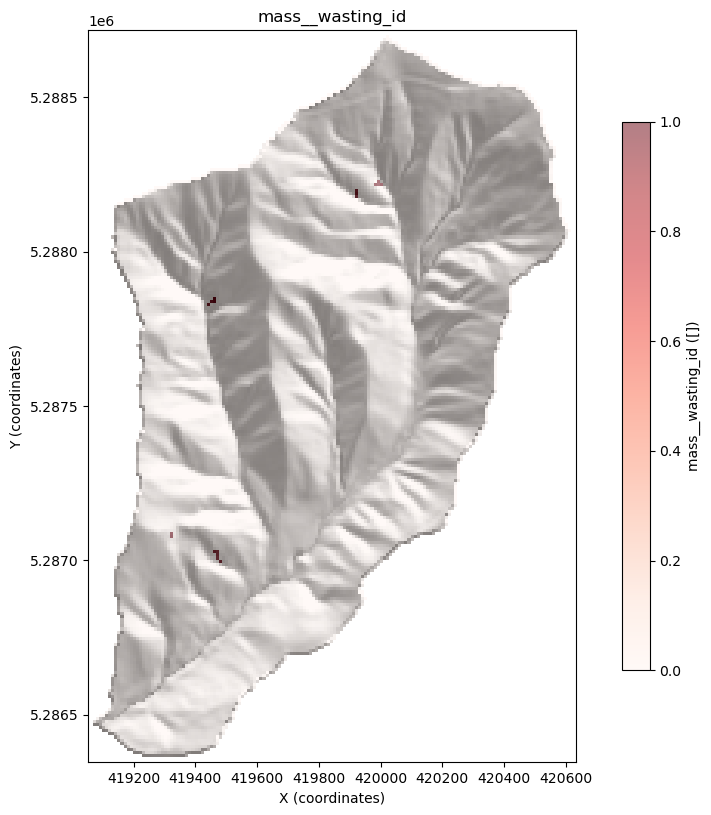

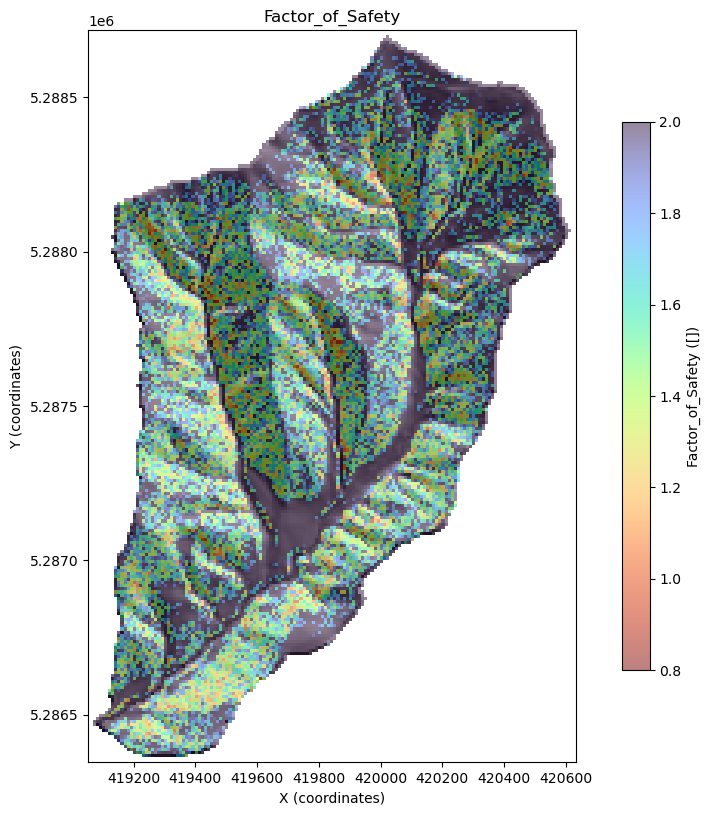

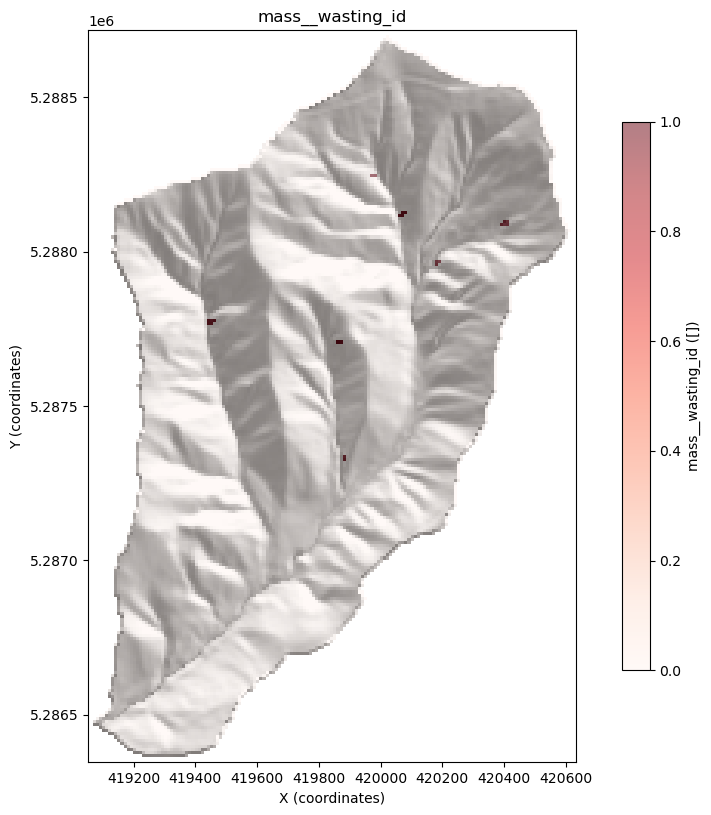

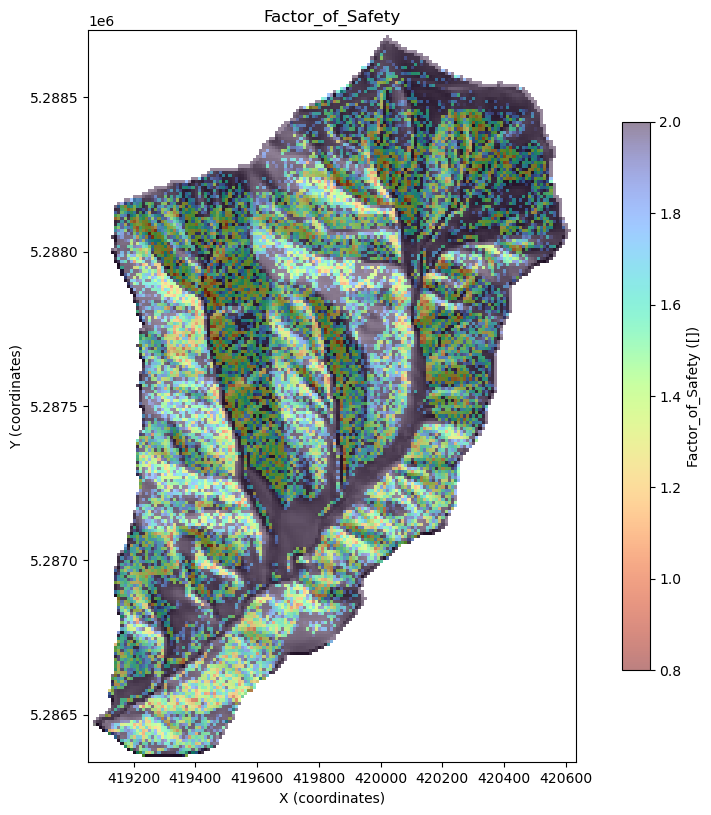

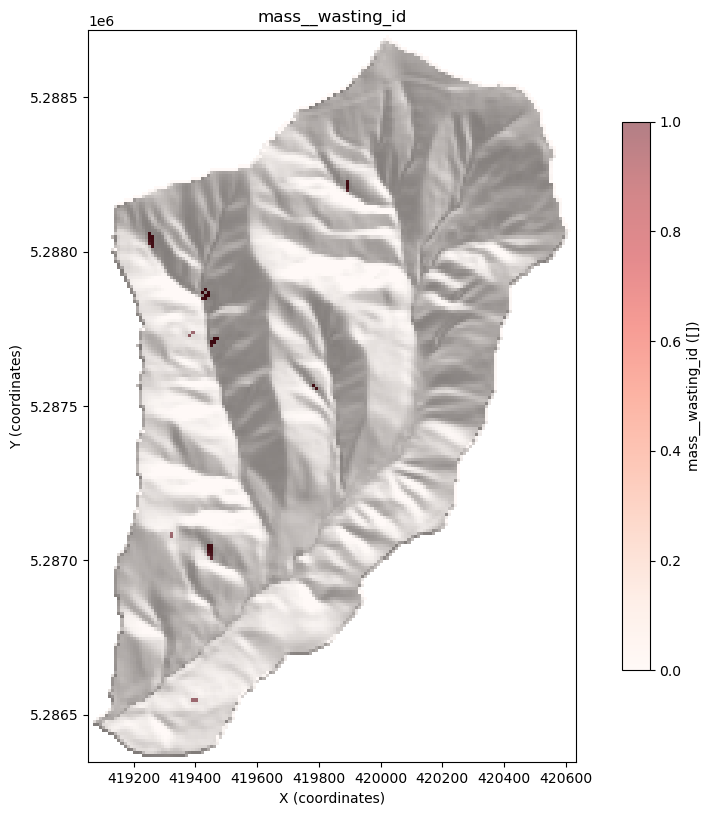

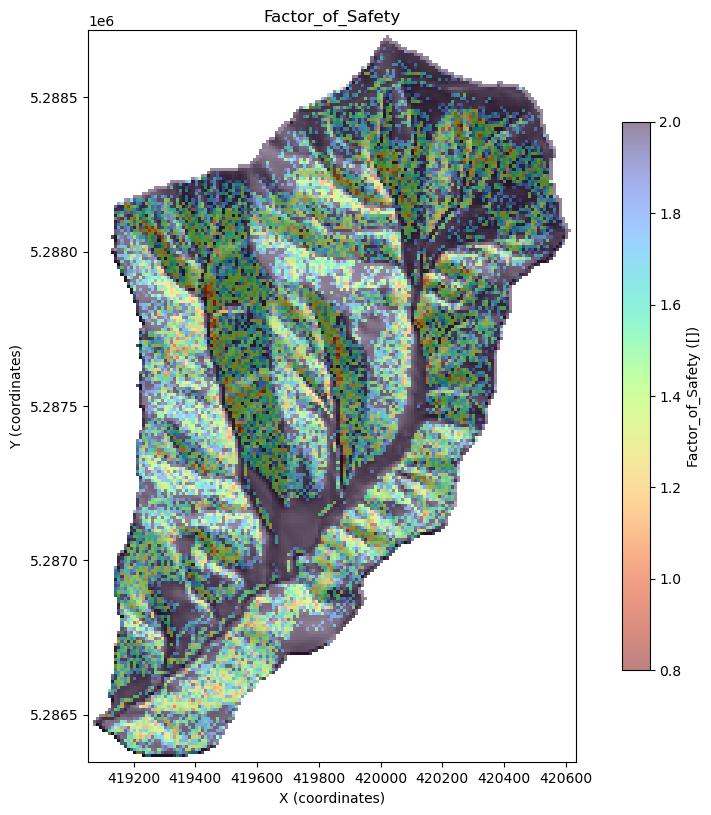

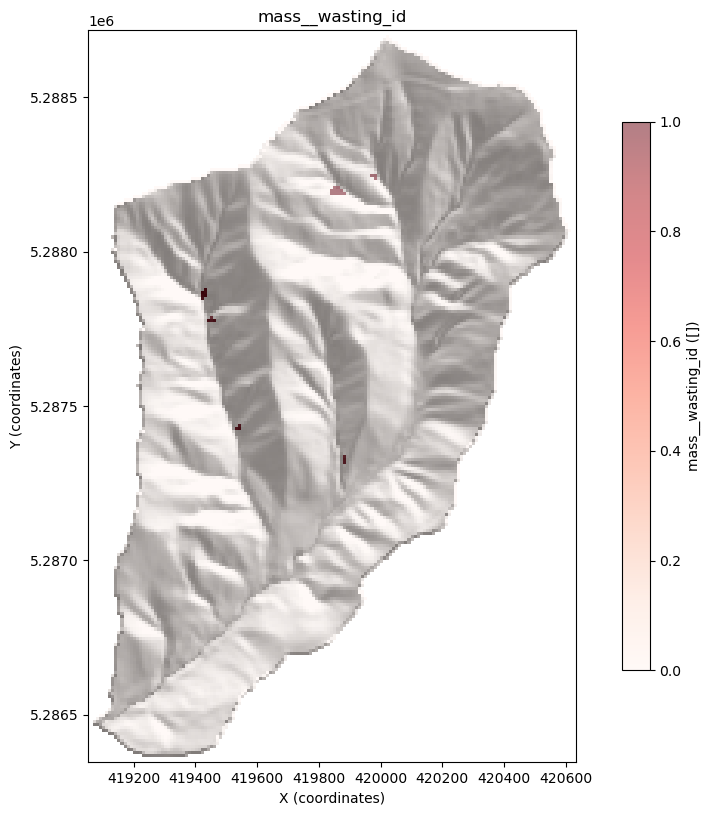

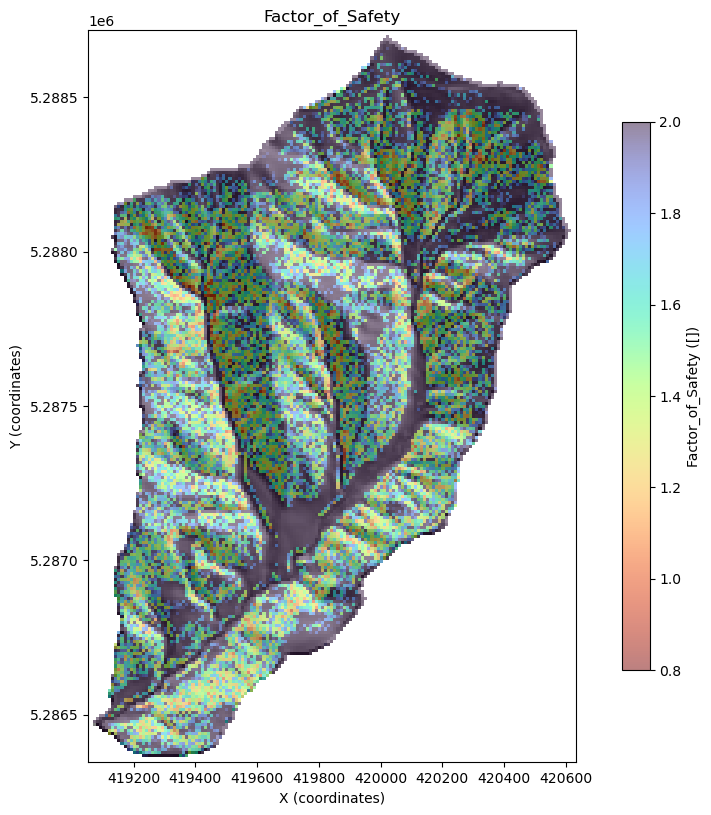

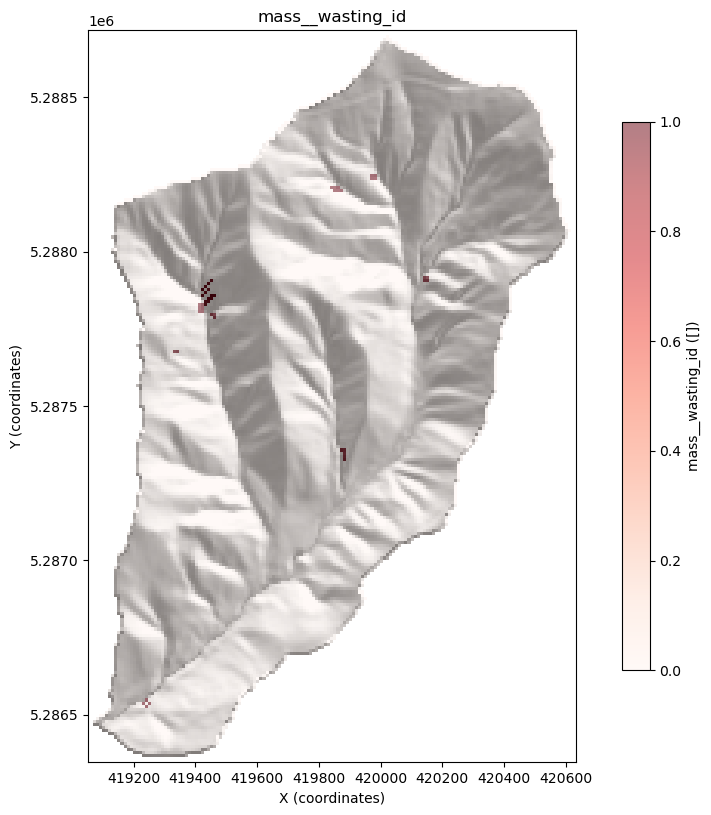

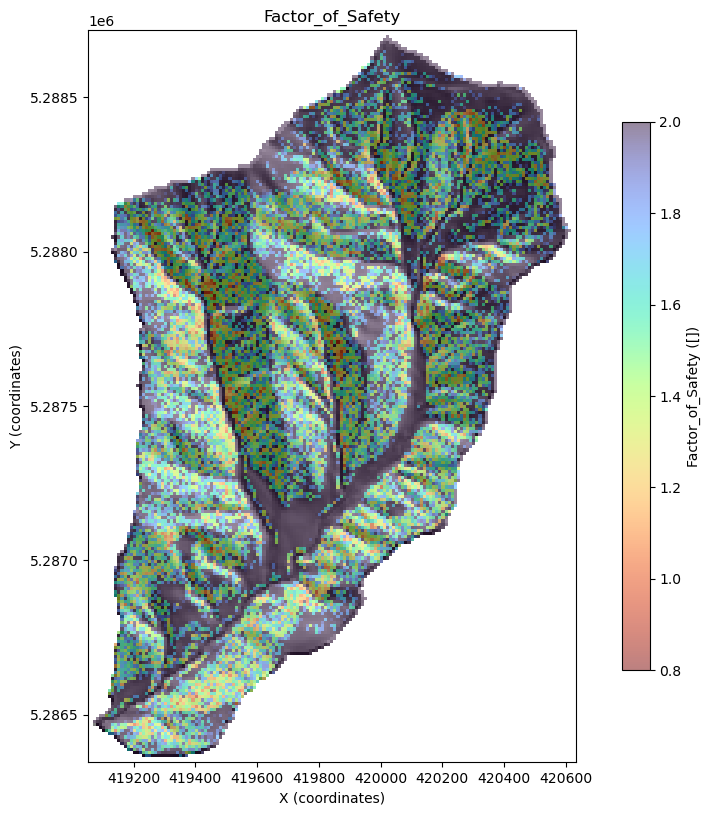

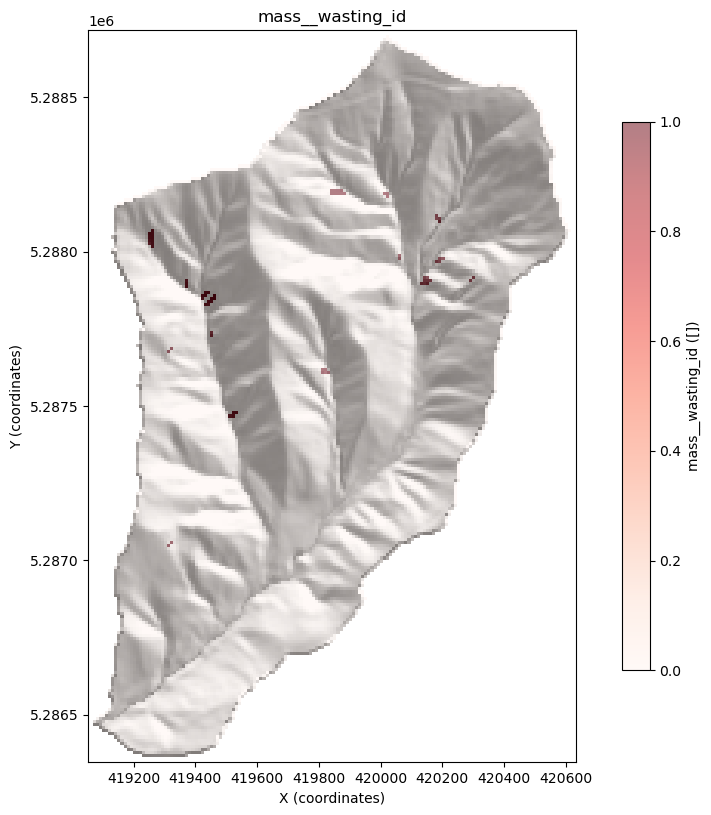

In [18]:
#%% separetly map the landslides
d8flowdirector(mg)
LSid_list = []
for c in range(ls_prob._FSarray.shape[1]):
    print("mapping the landslides, map:{}".format(c))
    mg.at_node['mass__wasting_potential'][mg.core_nodes] = ls_prob._FSarray[:,c]
    mg.at_node['Factor_of_Safety'] = mg.at_node['mass__wasting_potential']
    mg.at_node['ls_cells'] = np.zeros(mg.shape[0]*mg.shape[1])
    mg.at_node['ls_cells'][mg.at_node['mass__wasting_potential'] < mass_wasting_threshold] = 1
    
    Landslides.run_one_step()
    LSid_list.append(mg.at_node['mass__wasting_id'][mg.core_nodes])
    LLT.plot_node_field_with_shaded_dem(mg,plot_name = str(c), field = 'Factor_of_Safety', fontsize = 10, cmap = 'turbo_r')
    plt.clim(0.8,2)
    LLT.plot_node_field_with_shaded_dem(mg,plot_name = str(c)+'id', field = 'mass__wasting_id', fontsize = 10, cmap = 'Reds')
LSids = np.array(LSid_list).T    


In [19]:
mg.at_node.keys()

['topographic__elevation',
 'hillshade',
 'soil__thickness',
 'water__unit_flux_in',
 'drainage_area',
 'flow__data_structure_delta',
 'flow__upstream_node_order',
 'surface_water__discharge',
 'sediment_fill__depth',
 'soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area',
 'soil__mean_relative_wetness',
 'landslide__probability_of_failure',
 'soil__probability_of_saturation',
 'mass__wasting_potential',
 'mass__wasting_clumps',
 'energy__elevation',
 'topographic__initial_elevation',
 'disturbance_map',
 'flow__sink_flag',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'topographic__steepest_slope',
 'depression__depth',
 'depression__outlet_node',
 'is_pit',
 'flood_status_code',
 'Factor_of_Safety',
 'ls_cells',
 'mass__wasting_events',
 'mass__wasti

### now, model landslide runout using each landslide map

In [20]:
runout_dict = {}
for c in range(ls_prob._FSarray.shape[1]):
    
    # reset soil depth, grain size and topography
    mg.at_node['topographic__elevation'] = topographic__initial_elevation.copy()
    mg.at_node['soil__thickness'] = initial_soil_depth.copy()   
    mg.at_node['mass__wasting_id'][mg.core_nodes] = LSids[:,c]

    print("sending them down the hill, iteration {}".format(c))
    # reset flow director for new topography
    multidirectionflowdirector(mg) 
    # set soil depth to soil depth used in LandslideProbabilty iteration
    mg.at_node['soil__thickness'][mg.core_nodes] = ls_prob._hsarray[:,c]
    DebrisFlows.cs = np.random.uniform(0.02,0.04)
    DebrisFlows.slpc = np.random.uniform(0.07,0.15)
    
    PASS = False
    while PASS is False :
        DebrisFlows.SD = np.random.uniform(0.05,0.15)
        if DebrisFlows.SD > DebrisFlows.cs:
            PASS = True
    
    DebrisFlows.run_one_step(dt = c)
    
    runout_dict[c] = mg.at_node['topographic__elevation'] - topographic__initial_elevation
    print(c)

sending them down the hill, iteration 0
20
40
60
80
100
120
140
160
180
200
220
0
sending them down the hill, iteration 1
20
40
60
80
100
120
140
160
180
200
220
1
sending them down the hill, iteration 2
20
40
60
80
100
120
140
2
sending them down the hill, iteration 3
20
40
60
80
100
120
140
160
180
200
3
sending them down the hill, iteration 4
20
40
60
80
100
120
140
4
sending them down the hill, iteration 5
20
40
60
80
100
5
sending them down the hill, iteration 6
20
40
60
80
100
120
140
160
180
200
220
6
sending them down the hill, iteration 7
20
40
60
80
100
120
7
sending them down the hill, iteration 8
20
40
60
80
100
120
8
sending them down the hill, iteration 9
20
40
60
80
100
120
140
160
9


### compute landslide runout, landslide deposition and landslide erosion probability

In [21]:
runout_summary = pd.DataFrame.from_dict(runout_dict,orient = 'index')
ni = ls_prob._FSarray.shape[1] # number of iterations
runout_summary_c = runout_summary.copy()
runout_summary_s = runout_summary.copy()
runout_summary_d = runout_summary.copy()
runout_summary_c[np.abs(runout_summary_c)>0] = 1 
runout_summary_s[runout_summary_s>=0] = 0; runout_summary_s[runout_summary_s<0] = 1
depth_threshold = 1
runout_summary_d[runout_summary_d<=depth_threshold] = 0; runout_summary_d[runout_summary_d>depth_threshold] = 1

p_c = runout_summary_c.sum(axis=0)/ni
p_s = runout_summary_s.sum(axis=0)/ni
p_d = runout_summary_d.sum(axis=0)/ni

mg.at_node['probability__of_runout'] = p_c
mg.at_node['probability__of_scour'] = p_s
mg.at_node['probability__of_deposition'] = p_d


### view landslide runout, landslide deposition and landslide erosion probability

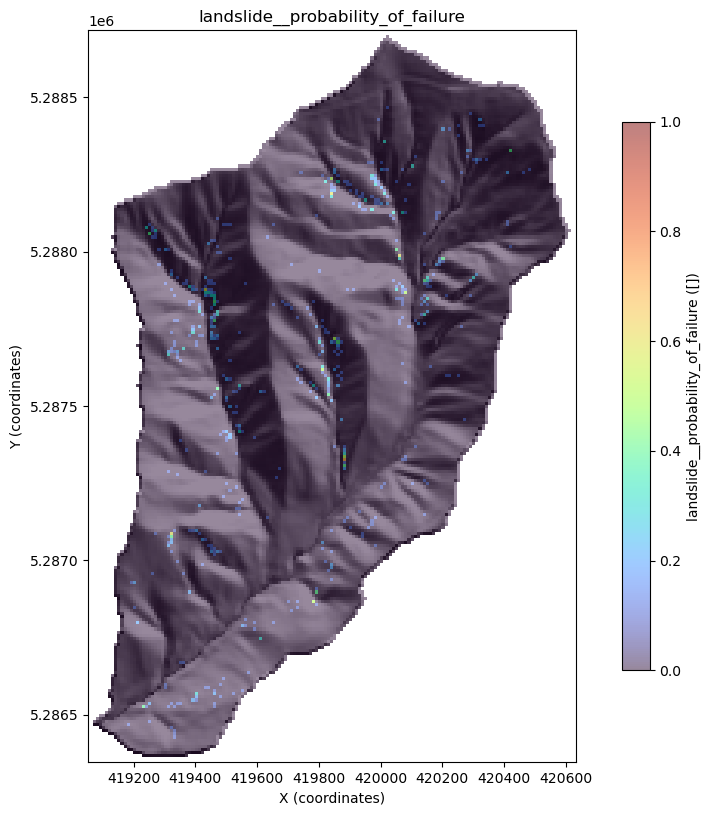

In [22]:
LLT.plot_node_field_with_shaded_dem(mg,field = 'landslide__probability_of_failure',fontsize = 10, cmap = 'turbo')
plt.clim(0,1)
# plt.savefig(mdir+'LSprob'+svnm+".png", dpi = 300, bbox_inches='tight')

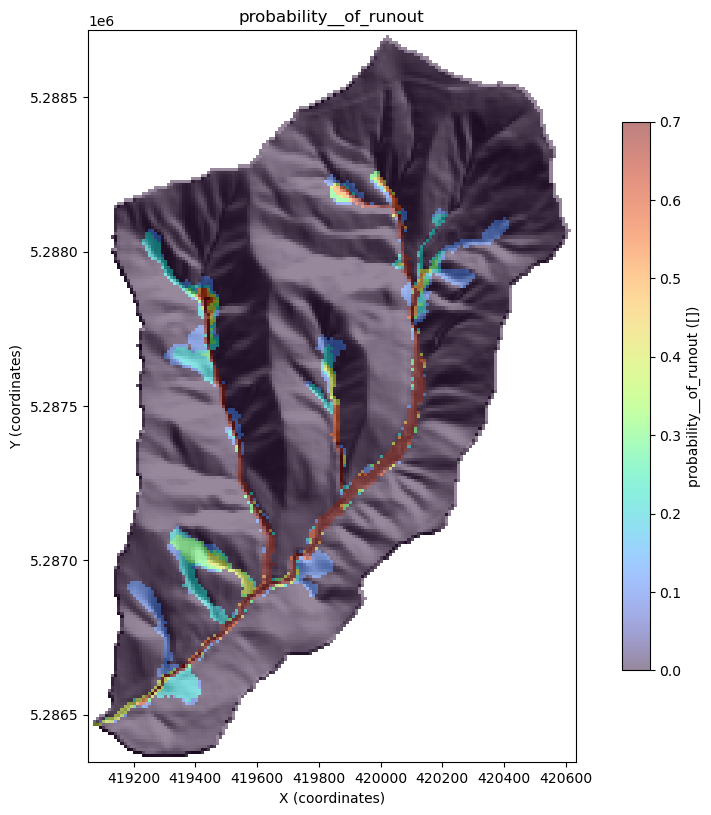

In [23]:
LLT.plot_node_field_with_shaded_dem(mg,field = 'probability__of_runout',fontsize = 10, cmap = 'turbo')
plt.clim(0,0.7)
# plt.savefig(mdir+'runout_prob'+svnm+".png", dpi = 300, bbox_inches='tight')


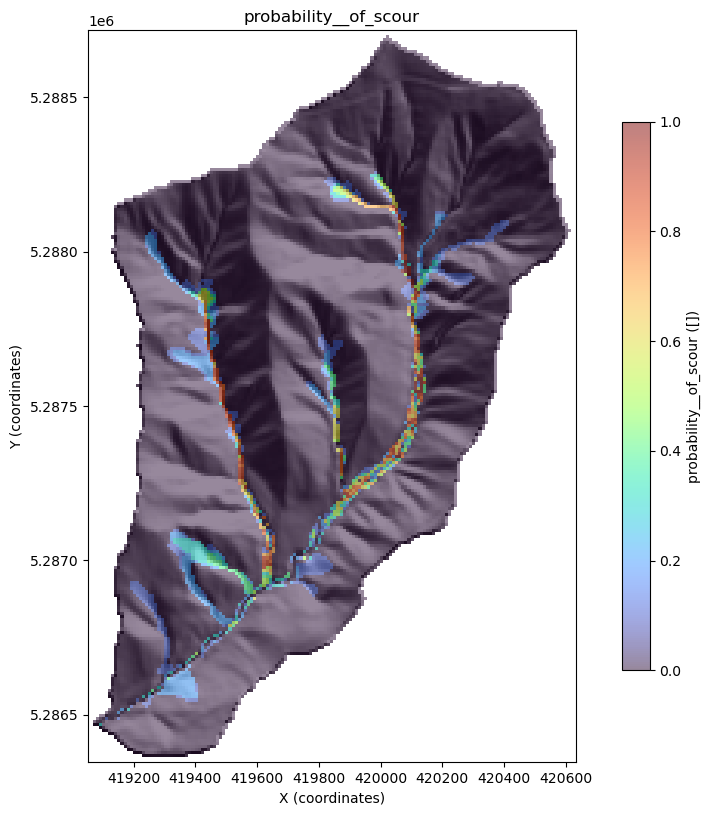

In [24]:
LLT.plot_node_field_with_shaded_dem(mg,field = 'probability__of_scour',fontsize = 10, cmap = 'turbo')
plt.clim(0,1)
# plt.savefig(mdir+'scour_prob'+svnm+".png", dpi = 300, bbox_inches='tight')

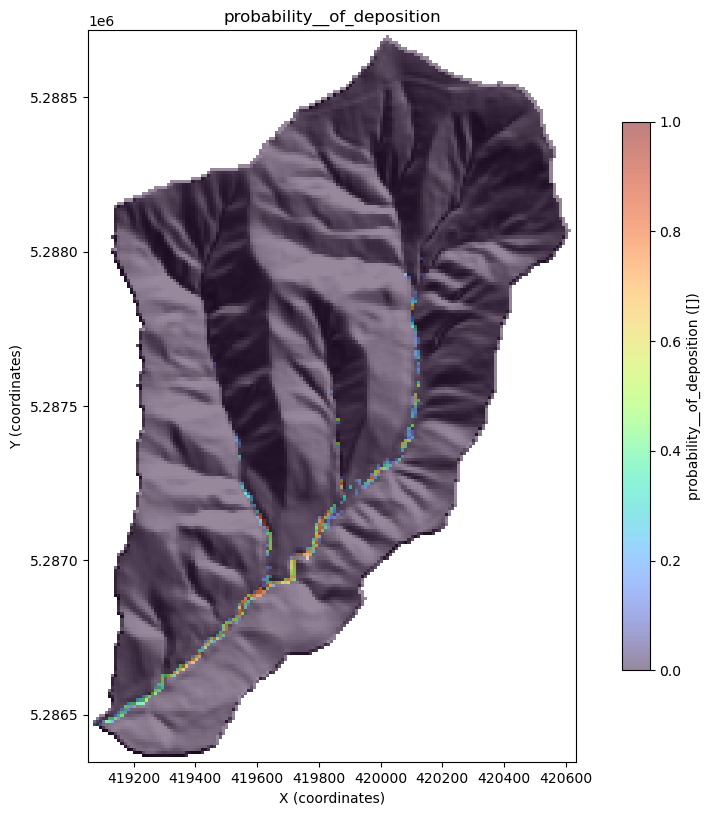

In [25]:
LLT.plot_node_field_with_shaded_dem(mg,field = 'probability__of_deposition',fontsize = 10, cmap = 'turbo')
plt.clim(0,1)